In [22]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

#from matplotlib import pyplot
import matplotlib.pyplot as plt

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [23]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

In [24]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [25]:
def print_confusion_matrix(tn, fp, fn, tp):
    print("    ","True", "False")
    print("True ", " ", tp, "  ", fp)
    print("False", " ",fn,"  ", tn)
    print("_______________________________________")
    print("---------------------------------------")

## XGBoost


In [100]:
X_train = read_csv('output/\CompleteIndexesWeeklyTrain_decomp.csv')
X_test = read_csv('output/\CompleteIndexesWeeklyTest_decomp.csv')

y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
y.index = y['date'].values
y = y[['regime']]
y = y['regime']=='BEAR'
y = pd.DataFrame (y, columns = ['regime'])

y_train = y.loc['2000-01-01':'2015-01-01']
y_test = y.loc['2015-01-02':]

#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
dtrain = xgb.DMatrix(X_train, label=y_train)

#param_test1 = {
#    'learning_rate':np.arange(0.01,0.05,0.1),
#    'n_estimators':[100, 200, 500, 1000],
#    'max_depth':range(2,6,1),
#    'subsample':np.arange(0.8,1,0.1),
#    'min_child_weight':range(1,6,2),
#    'colsample_bytree':np.arange(0.3,1,0.2),
#}
balance = np.sqrt(len(y_train[y_train['regime']==False])/len(y_train[y_train['regime']==True]))
param_test1 = {
    'learning_rate':[0.1], #np.arange(0.00001, 0.02,0.1),
    'n_estimators':[90],
    'max_depth':[1],
    'max_delta_step':[1],
    'subsample':[0.8],
    'min_child_weight':[3],
    'gamma': [5],
    'scale_pos_weight':[15],
    'colsample_bytree':[0.8],
    'reg_alpha':[1],
}

#param_test1 = {
#    'learning_rate':np.arange(0.01,0.02,0.1),
#    'n_estimators':[50, 65, 100, 200],
#    'max_depth':range(2,6,1),
#    'subsample':np.arange(0.8,1,0.1),
#    'min_child_weight':range(1,6,1),
#    'colsample_bytree':np.arange(0.3,1,0.1),
#}

tscv = TimeSeriesSplit(n_splits=5)

balance = np.sqrt(len(y_train[y_train['regime']==False])/len(y_train[y_train['regime']==True]))
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(objective="binary:logistic", 
                                                      #eval_metric = 'auc',
                                                      #disable_default_eval_metric = 1,
                                                      #gamma=1,
                                                      #scale_pos_weight=balance
                                                      ), 
                        param_grid = param_test1, 
                        #scoring='f1',
                        n_jobs=4,
                        cv=tscv)

gsearch1.fit(X_train, y_train)#, eval_metric=f1_eval)
print(gsearch1.best_params_, gsearch1.best_score_)

y_train_pred = gsearch1.predict(X_train)
print("_______________________________________")
print("______________Training_________________")
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)  
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("_______________Testing_________________")
y_pred = gsearch1.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*precision*recall/(precision+recall)
print("F1 score", f_score)
print_confusion_matrix(tn, fp, fn, tp)
print("---------------------------------------")


{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'max_delta_step': 1, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 90, 'reg_alpha': 1, 'scale_pos_weight': 15, 'subsample': 0.8} 0.7061538461538462
_______________________________________
______________Training_________________
F1 score 0.888622754491018
     True False
True    371    92
False   1    318
_______________________________________
---------------------------------------
_______________Testing_________________
F1 score 0.6808510638297872
     True False
True    48    28
False   17    179
_______________________________________
---------------------------------------
---------------------------------------


In [6]:


best_params = {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.0001, 'max_delta_step': 1, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 65, 'reg_alpha': 1e-05, 'scale_pos_weight': 5, 'subsample': 0.8}


#best_params = {'colsample_bytree': 0.9000000000000001,
#  'gamma': 0,
#  'learning_rate': 0.01,
#  'max_delta_step': 1,
#  'max_depth': 5,
#  'min_child_weight': 5,
#  'n_estimators': 90,
#  'scale_pos_weight': 10,
#  'subsample': 0.5}

In [7]:
def format(val, pos):
    if val == 0:
        return "BULL"
    if val == 1:
        return "BEAR"
    else:
        return ""

In [8]:
def plot(real, imputed):
    fig, ax = plt.subplots(figsize=(20,4))
    ax.xaxis.set_major_locator(plt.MaxNLocator(50))
    ax.plot(real.index, real, '-', label="Real Data", color='blue')
    ax.plot(real.index, imputed, '-', label="Imputed Data", color='red')
    ax.legend(['Real Data', 'Predicted Data'])
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format))
    ax.set_ylim(-0.1, 1.1)
    fig.autofmt_xdate()
    plt.show()

In [9]:
def run_experiment_multiple_times(best_params, n=30):
    result_dict = {}
    result_dict= {'f1':0, 'tn':0, 'fp':0, 'fn':0, 'tp':0, 'auc':0, 'best_f1':0, 'best_model':None, 'best_auc':0, 'best_f1':0, 'best_tn':0, 'best_fp':0, 'best_fn':0, 'best_tp':0}
    X_train = read_csv('output/\CompleteIndexesWeeklyTrain_decomp.csv')
    X_test = read_csv('output/\CompleteIndexesWeeklyTest_decomp.csv')


    y = pd.read_csv('input/\sp500_target_regimes.csv', parse_dates=True)
    y.index = y['date'].values
    y = y[['regime']]
    y = y['regime']=='BEAR'
    y = pd.DataFrame (y, columns = ['regime'])

    y_train = y.loc['2000-01-01':'2015-01-01']
    y_test = y.loc['2015-01-02':]

    for i in range(0,n):
        balance = np.sqrt(len(y_train[y_train['regime']==False])/len(y_train[y_train['regime']==True]))
        xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                                          eval_metric = 'auc',
                                          learning_rate=best_params['learning_rate'], 
                                          n_estimators=best_params['n_estimators'], 
                                          min_child_weight=best_params['min_child_weight'], 
                                          gamma=best_params['gamma'],
                                          max_delta_step=best_params['max_delta_step'],
                                          max_depth=best_params['max_depth'],
                                          subsample=best_params['subsample'],
                                          scale_pos_weight=best_params['scale_pos_weight'],
                                          colsample_bytree=best_params['colsample_bytree'],
                                          reg_alpha=best_params['reg_alpha']
                                      )

        model = xgb_model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f_score = (2*precision*recall/(precision+recall))
        result_dict['f1'] += f_score
        result_dict['tn'] += tn
        result_dict['fp'] += fp
        result_dict['fn'] += fn
        result_dict['tp'] += tp
        result_dict['auc'] += gsearch1.best_score_
        if result_dict['best_f1'] < f_score:
            result_dict['best_f1'] = f_score
            result_dict['best_model'] = model
            result_dict['best_tn'] = tn
            result_dict['best_fp'] = fp
            result_dict['best_fn'] = fn
            result_dict['best_tp'] = tp
            result_dict['best_auc'] = gsearch1.best_score_
            result_dict['best_params'] = gsearch1.best_params_
        

    #plot bear bull imputed and real
    plot(y_test, y_pred)
    # feature importance
    data = pd.DataFrame(data=xgb_model.feature_importances_, index=X_train.columns, columns=["score"]).sort_values(by = "score", ascending=False)
    data.plot(kind='barh', title="Predicted v. Real", figsize=(10,10))

    result_dict['f1'] = result_dict['f1']/n
    result_dict['tn'] = result_dict['tn']/n
    result_dict['fp'] = result_dict['fp']/n
    result_dict['fn'] = result_dict['fn']/n
    result_dict['tp'] = result_dict['tp']/n
    result_dict['auc'] = result_dict['auc']/n
        
    return result_dict     

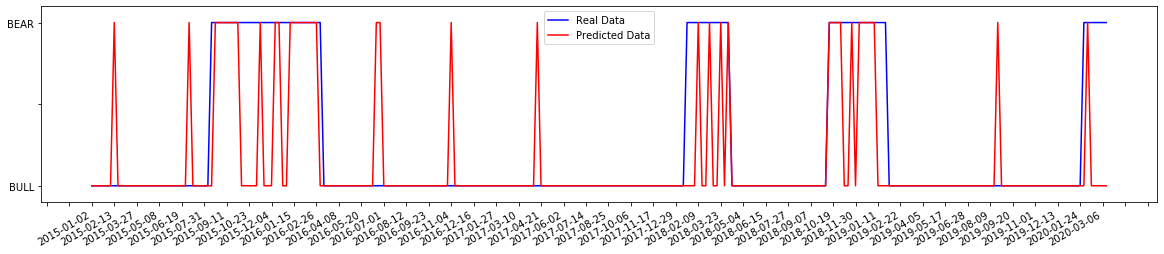

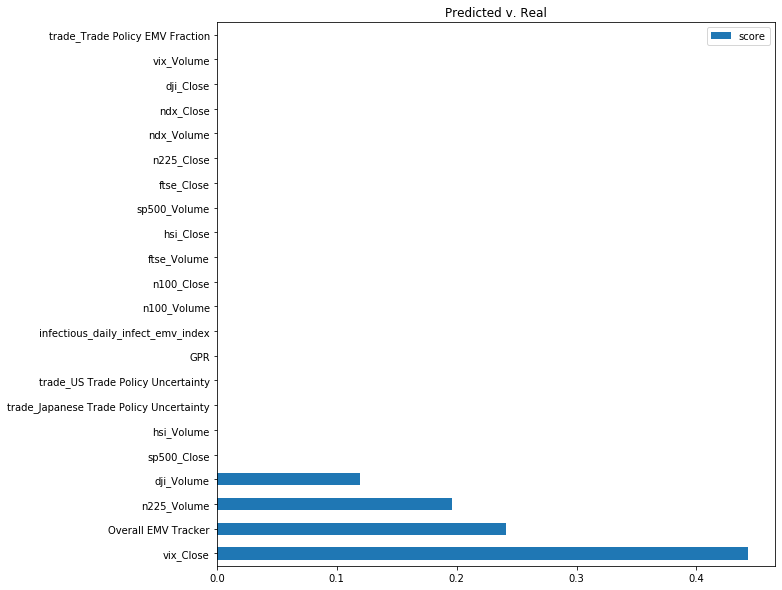

In [10]:
result_dict = run_experiment_multiple_times(gsearch1.best_params_, n=1)

In [11]:
result_dict

{'f1': 0.6285714285714286,
 'tn': 200.0,
 'fp': 7.0,
 'fn': 32.0,
 'tp': 33.0,
 'auc': 0.6092307692307692,
 'best_f1': 0.6285714285714286,
 'best_model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
               gamma=5, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.0001,
               max_delta_step=1, max_depth=1, min_child_weight=2, missing=nan,
               monotone_constraints='()', n_estimators=65, n_jobs=0,
               num_parallel_tree=1, random_state=0, reg_alpha=1e-05,
               reg_lambda=1, scale_pos_weight=1, subsample=0.8,
               tree_method='exact', validate_parameters=1, verbosity=None),
 'best_auc': 0.6092307692307692,
 'best_tn': 200,
 'best_fp': 7,
 'best_fn': 32,
 'best_tp': 33,
 'best_params': {'colsample_bytree': 0.8,
  'gamma': 5,
  'learning_rate': 0.0001,
  'max_delta_step': 1,
  'max_depth': 1,

In [12]:
print("Average F1 Score", result_dict['f1'])
print_confusion_matrix(result_dict['tn'], result_dict['fp'], result_dict['fn'], result_dict['tp'])
print("_______________________________________________________________________________")
print("Best F1 Score", result_dict['best_f1'])
print_confusion_matrix(result_dict['best_tn'], result_dict['best_fp'], result_dict['best_fn'], result_dict['best_tp'])
print("_______________________________________________________________________________")

Average F1 Score 0.6285714285714286
     True False
True    33.0    7.0
False   32.0    200.0
_______________________________________
---------------------------------------
_______________________________________________________________________________
Best F1 Score 0.6285714285714286
     True False
True    33    7
False   32    200
_______________________________________
---------------------------------------
_______________________________________________________________________________
